In [25]:
#Define a simple CNN classifier 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 64, 6, padding = 3)
        self.conv2 = nn.Conv1d(64, 64, 6, padding = 3)
        self.conv3 = nn.Conv1d(64, 64, 3, padding = 1)
        self.dropout = nn.Dropout(p=0.5) 
        self.pool = nn.MaxPool1d(3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 100)
        self.fc2 = nn.Linear(100, 9)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [2]:
import sys
sys.path.append('../')
from UNIMIB import *
from torch.utils import data

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
real_data = unimib_load_dataset(data_mode = 'Train', single_class = False)
real_loader = data.DataLoader(real_data, batch_size=16, num_workers=4, shuffle = True)

x_train shape is (6055, 3, 144), x_test shape is (1524, 3, 144)
y_train shape is (6055,), y_test shape is (1524,)


In [4]:
syn_data = syn_unimib(file_folder = './synthetic_data/')
syn_loader = data.DataLoader(syn_data, batch_size=16, num_workers=4, shuffle = True)

Data shape is (9000, 3, 144)
Label shape is (9000,)


In [5]:
mixed_data = mixed_unimib(file_folder = './synthetic_data/', n_samples = 1000)
mixed_loader = data.DataLoader(mixed_data, batch_size=16, num_workers=4, shuffle = True)

x_train shape is (6055, 3, 144), x_test shape is (1524, 3, 144)
y_train shape is (6055,), y_test shape is (1524,)
Data shape is (9000, 3, 144)
Label shape is (9000,)
Mixed Data shape is (15055, 3, 144)
Mixed Label shape is (15055,)


In [6]:
test_set = unimib_load_dataset(incl_xyz_accel = True, incl_rms_accel = False, incl_val_group = False, is_normalize = True, one_hot_encode = False, data_mode = 'Test', single_class = False)
test_loader = data.DataLoader(test_set, batch_size=16, num_workers=4, shuffle = True)

x_train shape is (6055, 3, 144), x_test shape is (1524, 3, 144)
y_train shape is (6055,), y_test shape is (1524,)


In [16]:
def train(model, train_data_loader, test_data_loader, epochs, criterion, optimizer):
    for epoch in range(epochs):  # loop over the dataset multiple times
        model.train()
        total_loss = 0.0
        total = 0
        correct = 0

        for i, data in enumerate(train_data_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            total_loss += loss.item()

#             y_pred = torch.round(torch.sigmoid(outputs))
# #             y_pred = torch.round(outputs)
#             correct = (y_pred == labels).sum()
#             total_correct += correct
#             total += len(labels)
            
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

        epoch_train_loss = total_loss / len(train_data_loader)
        epoch_train_acc = correct / total
        print(f'Epoch {epoch + 1}, train loss = {epoch_train_loss}, train acc = {epoch_train_acc}')

        if (epoch+1) % 5 == 0:
            _eval(model, test_data_loader, criterion, epoch)
            _eval_single_class(model, test_data_loader, criterion, epoch)
            
    _final_eval(model, test_data_loader, criterion)

    print('Finished Training and testing')

In [15]:
def _eval(model, real_test_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            total_loss += loss.item()

#             y_pred = torch.round(torch.sigmoid(outputs))
#             correct = (y_pred == labels).sum()
#             total_correct += correct
#             total += len(labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_test_loss = total_loss / len(real_test_loader)
        epoch_test_acc = correct / total
    
    print('=====================================================')
    print(f'Epoch {epoch+1}, test loss = {epoch_test_loss}, test acc = {epoch_test_acc}')
    print('=====================================================')

In [13]:
classes = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']

In [14]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

In [11]:
def _eval_single_class(model, real_test_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            total_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                       accuracy))

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def _final_eval(model, real_test_loader, criterion):
    nb_classes = 9
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    target_names = classes
    y_preds = []
    y_trues = []
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()
            
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,predictions.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
            
            y_preds.append(predictions)
            y_trues.append(labels)
            
    # Confusion matrix
    cm=confusion_matrix(lbllist.numpy(), predlist.numpy())
    print(cm)
    cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
    fig = plt.figure(figsize=(6.5,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
    plt.title('CNN UniMiB data classification Accuracy')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout() # keeps labels from being cutoff when saving as pdf
#     plt.savefig("./images/mixedfourCM.pdf", format="pdf")
    plt.show()
    
    # Per-class accuracy
    class_accuracy = 100*cm.diagonal() / cm.sum(1)
    print(class_accuracy)
    
    #print classification report 
#     y_preds = np.array(y_preds)
#     y_trues = np.array(y_trues)
    y_preds_flatten = [label for sublist in y_preds for label in sublist]
    y_trues_flatten = [label for sublist in y_trues for label in sublist]
#     y_preds = y_preds.flatten()
#     y_trues = y_trues.flatten()
    print(classification_report(y_trues_flatten, y_preds_flatten, target_names=classes))

Epoch 1, train loss = 1.995696505578388, train acc = 0.23534269199009084
Epoch 2, train loss = 1.8793391510789388, train acc = 0.2617671345995045
Epoch 3, train loss = 1.872092747021837, train acc = 0.2662262592898431
Epoch 4, train loss = 1.8619693038756153, train acc = 0.2754748142031379
Epoch 5, train loss = 1.8363820995217988, train acc = 0.29843104872006604
Epoch 5, test loss = 1.8742418632406002, test acc = 0.4311023622047244
Accuracy for class StandingUpFS is: 60.4 %
Accuracy for class StandingUpFL is: 50.5 %
Accuracy for class Walking is: 80.4 %
Accuracy for class Running is: 93.4 %
Accuracy for class GoingUpS is: 68.7 %
Accuracy for class Jumping is: 68.9 %
Accuracy for class GoingDownS is: 74.0 %
Accuracy for class LyingDownFS is: 52.7 %
Accuracy for class SittingDown is: 71.0 %
Epoch 6, train loss = 1.724760668087877, train acc = 0.3988439306358382
Epoch 7, train loss = 1.3841603789441272, train acc = 0.5379025598678778
Epoch 8, train loss = 1.1415231565111774, train acc = 0

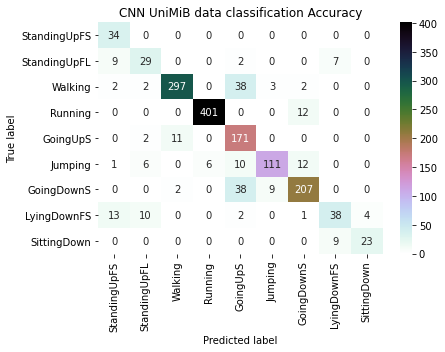

[100.          61.70212766  86.3372093   97.09443099  92.93478261
  76.02739726  80.859375    55.88235294  71.875     ]
              precision    recall  f1-score   support

StandingUpFS       0.58      1.00      0.73        34
StandingUpFL       0.59      0.62      0.60        47
     Walking       0.96      0.86      0.91       344
     Running       0.99      0.97      0.98       413
    GoingUpS       0.66      0.93      0.77       184
     Jumping       0.90      0.76      0.83       146
  GoingDownS       0.88      0.81      0.84       256
 LyingDownFS       0.70      0.56      0.62        68
 SittingDown       0.85      0.72      0.78        32

    accuracy                           0.86      1524
   macro avg       0.79      0.80      0.78      1524
weighted avg       0.88      0.86      0.86      1524

Finished Training and testing


In [28]:
# Define training hyperparameters
import torch.optim as optim
real_model = Net()
real_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(real_model.parameters(), lr=0.0005, momentum=0.9)
train(real_model, real_loader, test_loader, 50, criterion, optimizer)

Epoch 1, train loss = 2.147869869394405, train acc = 0.17748256393224843
Epoch 2, train loss = 2.059501215164914, train acc = 0.23135171039521754
Epoch 3, train loss = 1.5431255467122702, train acc = 0.457588840916639
Epoch 4, train loss = 0.9402536546711341, train acc = 0.6570574559946861
Epoch 5, train loss = 0.6775086489255421, train acc = 0.7606775157754899
Epoch 5, test loss = 0.7190755364176796, test acc = 0.7933070866141733
Accuracy for class StandingUpFS is: 67.2 %
Accuracy for class StandingUpFL is: 55.3 %
Accuracy for class Walking is: 80.0 %
Accuracy for class Running is: 93.1 %
Accuracy for class GoingUpS is: 76.9 %
Accuracy for class Jumping is: 74.4 %
Accuracy for class GoingDownS is: 80.8 %
Accuracy for class LyingDownFS is: 56.9 %
Accuracy for class SittingDown is: 74.7 %
Epoch 6, train loss = 0.5606180653394066, train acc = 0.8040518100298905
Epoch 7, train loss = 0.48535095565934117, train acc = 0.8308867485885088
Epoch 8, train loss = 0.4480367787696253, train acc = 

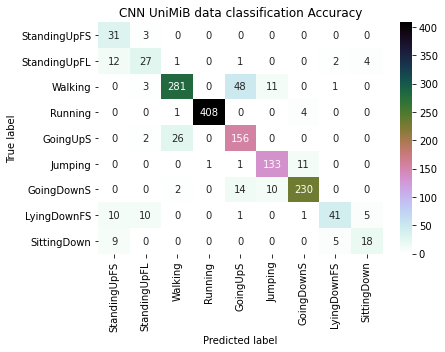

[91.17647059 57.44680851 81.68604651 98.78934625 84.7826087  91.09589041
 89.84375    60.29411765 56.25      ]
              precision    recall  f1-score   support

StandingUpFS       0.50      0.91      0.65        34
StandingUpFL       0.60      0.57      0.59        47
     Walking       0.90      0.82      0.86       344
     Running       1.00      0.99      0.99       413
    GoingUpS       0.71      0.85      0.77       184
     Jumping       0.86      0.91      0.89       146
  GoingDownS       0.93      0.90      0.92       256
 LyingDownFS       0.84      0.60      0.70        68
 SittingDown       0.67      0.56      0.61        32

    accuracy                           0.87      1524
   macro avg       0.78      0.79      0.77      1524
weighted avg       0.88      0.87      0.87      1524

Finished Training and testing


In [29]:
# Define training hyperparameters
import torch.optim as optim
mixed_model = Net()
mixed_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mixed_model.parameters(), lr=0.0005, momentum=0.9)
train(mixed_model, mixed_loader, test_loader, 50, criterion, optimizer)